In [ ]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential


from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork


#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network_lncbase_filtered_nodes_train.pickle', 'rb') as file:
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_biogrid.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list
# network.G.number_of_edges()

In [3]:
# READ edgelists
with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network_lncbase_filtered_nodes_test.pickle', 'rb') as file:
    network_test = pickle.load(file)
    
with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network_lncbase_filtered_nodes_val.pickle', 'rb') as file:
    network_val = pickle.load(file)

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

KeyError: nan

# Training Source Target Graph Embedding

In [10]:
from keras.layers import Input, Conv1D, Lambda, Dot, Dense, Flatten, MaxPooling1D, Lambda, Convolution1D, Layer
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.utils import multi_gpu_model
import keras

from keras.optimizers import SGD, Adam, RMSprop
from keras.losses import binary_crossentropy
from keras.metrics import kullback_leibler_divergence, binary_crossentropy, binary_accuracy

from keras.utils import to_categorical

from keras.callbacks import TensorBoard


In [11]:
K.clear_session()
tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))
# sess = tf.InteractiveSession()

In [12]:
# INPUT PARAMETERS
max_length = 700
input_shape = (None, 6)
batch_size = 1024

_d = 256

In [13]:
# Inputs
E_ij = Input(batch_shape=(batch_size, 1), name="E_ij")
input_seq_i = Input(batch_shape=(batch_size, *input_shape), name="input_seq_i")
input_seq_j = Input(batch_shape=(batch_size, *input_shape), name="input_seq_j")
is_directed = Input(batch_shape=(batch_size, 1), dtype=tf.bool, name="is_directed")

In [14]:
# Distance functions
def euclidean_distance(inputs):
    x, y = inputs
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def switch_emb(inputs):
    emb_i, emb_j, is_directed = inputs
    return K.switch(is_directed, 
                    [emb_i[:, 0:int(_d/2)] - emb_j[:, int(_d/2):_d]], [emb_i, emb_j]) 

def st_euclidean_distance(inputs):
    emb_i, emb_j, is_directed = inputs
    sum_directed = K.sum(K.square(emb_i[:, 0:int(_d/2)] - emb_j[:, int(_d/2):_d]), axis=1, keepdims=True)
    sum_undirected = K.sum(K.square(emb_i - emb_j), axis=1, keepdims=True)
    sum_switch = K.switch(is_directed, sum_directed, sum_undirected)
    return K.sqrt(K.maximum(sum_switch, K.epsilon()))

def st_embedding_probability(inputs):
    emb_i, emb_j, is_directed = inputs
    dot_directed = Dot(axes=1)([emb_i[:, 0:int(_d/2)], emb_j[:, int(_d/2):_d]])
    dot_undirected = Dot(axes=1)([emb_i, emb_j])
    return K.switch(is_directed, K.sigmoid(dot_directed), K.sigmoid(dot_undirected))

def st_embedding_probability_w_dense(inputs):
    emb_i, emb_j, is_directed = inputs
    directed = Dense(1, activation='sigmoid')(Dot(axes=1)([emb_i[:, 0:int(_d/2)], emb_j[:, int(_d/2):_d]]))
    undirected = Dense(1, activation='sigmoid')(Dot(axes=1)([emb_i, emb_j]))
    return K.switch(is_directed, directed, undirected)

def st_l1_distance(inputs):
    emb_i, emb_j, is_directed = inputs
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    directed_distance = Dense(1, activation='sigmoid')(L1_layer([emb_i[:, 0:int(_d/2)], emb_j[:, int(_d/2):_d]]))
    undirected_distance = Dense(1, activation='sigmoid')(L1_layer([emb_i, emb_j]))
    
    return K.switch(is_directed, directed_distance, undirected_distance)

In [15]:
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.regularizers import l2

def create_base_network(input_shape):
    """ Base network to be shared (eq. to feature extraction).
    """
    input = Input(shape=input_shape)
#     x = Flatten()(input)
    x = Convolution1D(filters=192, kernel_size=6, input_shape=input_shape, activation='relu')(input)
    print("conv1d_1", x)
    x = MaxPooling1D(pool_size=3, padding="same")(x)
    print("max pooling_1", x)
    
    x = Convolution1D(filters=320, kernel_size=3, activation='relu')(x)
    print("conv1d_2", x)
    x = MaxPooling1D(pool_size=3, padding="same")(x)
    print("max pooling_2", x)
    
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(320, return_sequences=False, return_state=False))(x)
    print("brnn", x)
    x = Dropout(0.3)(x)
    
    x = Dense(925, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(925, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(_d, activation='linear')(x) # Embedding space
    print("embedding", x)
    return Model(input, x)

In [16]:
# Loss function
def contrastive_loss(y_true, y_pred):
    ''' Contrastive loss from Hadsell-et-al.'06 
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1.0
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def regularized_cross_entropy(y_true, y_pred):
    return K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

def kl_loss(y_true, y_pred):
    return -K.mean(y_true * K.log(y_pred))

# Metrics
def accuracy(y_true, y_pred):
    ''' Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    y_pred = K.cast(y_pred < 0.5, y_true.dtype)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    y_pred = K.cast(y_pred < 0.5, y_true.dtype)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auc_roc(y_true, y_pred):
    # any tensorflow metric
    y_pred = K.exp(-2 * y_pred)
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [ ]:
# build create_base_network to use in each siamese 'leg'

with tf.device("/cpu:0"):
    lstm_network = create_base_network(input_shape=input_shape)

    print("lstm_network.input", lstm_network.input)
    print("lstm_network.output", lstm_network.output)
    print("input_seq_i", input_seq_i)
    print("input_seq_j", input_seq_j)

    # encode each of the two inputs into a vector with the convnet
    encoded_i = lstm_network(input_seq_i)
    encoded_j = lstm_network(input_seq_j)
    print("encoded_i", encoded_i, "\nencoded_j", encoded_j)

    distance = Lambda(st_euclidean_distance)([encoded_i, encoded_j, is_directed])
    print("distance", distance)

    siamese_net = Model(inputs=[input_seq_i, input_seq_j, is_directed], outputs=distance)

conv1d_1 Tensor("conv1d_1/Relu:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_2/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)


In [ ]:
siamese_net = multi_gpu_model(siamese_net, gpus=4, cpu_merge=True, cpu_relocation=False)

In [16]:
from keras.callbacks import Callback, EarlyStopping

# tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
my_callbacks = [EarlyStopping(monitor='auc_roc', patience=300, verbose=1, mode='max')]

In [124]:
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss=contrastive_loss, 
                    optimizer=RMSprop(),
                    metrics=[accuracy, precision, recall, auc_roc],
#                     callbacks=my_callbacks
                   )

siamese_net.count_params()


2662685

# Data Generator

In [19]:
from moge.network.data_generator import DataGenerator

truncating = "random"
negative_sampling_ratio = 2.0 # 1497 steps, 1865s/epoch at 2.0, 
generator_train = DataGenerator(network=network, negative_sampling_ratio=negative_sampling_ratio,
                          maxlen=max_length, padding='post', truncating=truncating,
                          batch_size=batch_size, dim=input_shape, 
                          shuffle=True, seed=0)

generator_test = DataGenerator(network=network_test, negative_sampling_ratio=negative_sampling_ratio,
                          maxlen=max_length, padding='post', truncating=truncating,
                          batch_size=batch_size, dim=input_shape, 
                          shuffle=True, seed=0)

X, y = generator_train.__getitem__(0)
print("X:", [(k, v.shape) for k, v in X.items()], "\ny:", y.shape)
# X, y = generator_test.__getitem__(0)
# print("X:", [(k, v.shape) for k, v in X.items()], "\ny:", y.shape)

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: 2572
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 407580 , Eu_count: 137644 , En_count: 384396
Ens_count: 815160
Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: 2572
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 4858 , Eu_count: 3255 , En_count: 4570
Ens_count: 9716
X: [('input_seq_j', (1024, 700, 6)), ('input_seq_i', (1024, 700, 6)), ('is_directed', (1024, 1))] 
y: (1024, 1)


# Train

In [20]:
history = siamese_net.fit_generator(generator_train, epochs=10, validation_data=generator_test,
                                    use_multiprocessing=True, workers=8)

Epoch 1/10
907/907 [==============================] - 1080s 1s/step - loss: 0.1574 - accuracy: 0.8232 - precision: 0.8319 - recall: 0.5752 - auc_roc: 0.7426 - val_loss: 0.0793 - val_accuracy: 0.8975 - val_precision: 0.9588 - val_recall: 0.7488 - val_auc_roc: 0.8521
Epoch 2/10
907/907 [==============================] - 1067s 1s/step - loss: 0.0787 - accuracy: 0.9006 - precision: 0.9264 - recall: 0.7408 - auc_roc: 0.8846 - val_loss: 0.0713 - val_accuracy: 0.9020 - val_precision: 0.9688 - val_recall: 0.7547 - val_auc_roc: 0.9068
Epoch 3/10
907/907 [==============================] - 1070s 1s/step - loss: 0.0688 - accuracy: 0.9125 - precision: 0.9244 - recall: 0.7854 - auc_roc: 0.9193 - val_loss: 0.0592 - val_accuracy: 0.9263 - val_precision: 0.9381 - val_recall: 0.8551 - val_auc_roc: 0.9292
Epoch 4/10
907/907 [==============================] - 1072s 1s/step - loss: 0.0633 - accuracy: 0.9198 - precision: 0.9257 - recall: 0.8097 - auc_roc: 0.9361 - val_loss: 0.0527 - val_accuracy: 0.9322 - v

In [ ]:
history = siamese_net.fit_generator(generator_train, epochs=20, validation_data=generator_test, initial_epoch=11,
                                    use_multiprocessing=True, workers=8)

Epoch 12/20
906/907 [============================>.] - ETA: 1s - loss: 0.0497 - accuracy: 0.9393 - precision: 0.9335 - recall: 0.8681 - auc_roc: 0.9689

907/907 [==============================] - 1074s 1s/step - loss: 0.0497 - accuracy: 0.9393 - precision: 0.9335 - recall: 0.8681 - auc_roc: 0.9689 - val_loss: 0.0441 - val_accuracy: 0.9480 - val_precision: 0.9491 - val_recall: 0.9063 - val_auc_roc: 0.9697
Epoch 13/20
907/907 [==============================] - 1072s 1s/step - loss: 0.0488 - accuracy: 0.9404 - precision: 0.9340 - recall: 0.8710 - auc_roc: 0.9705 - val_loss: 0.0430 - val_accuracy: 0.9472 - val_precision: 0.9439 - val_recall: 0.9093 - val_auc_roc: 0.9712
Epoch 14/20
 39/907 [>.............................] - ETA: 17:10 - loss: 0.0487 - accuracy: 0.9403 - precision: 0.9367 - recall: 0.8696 - auc_roc: 0.9713

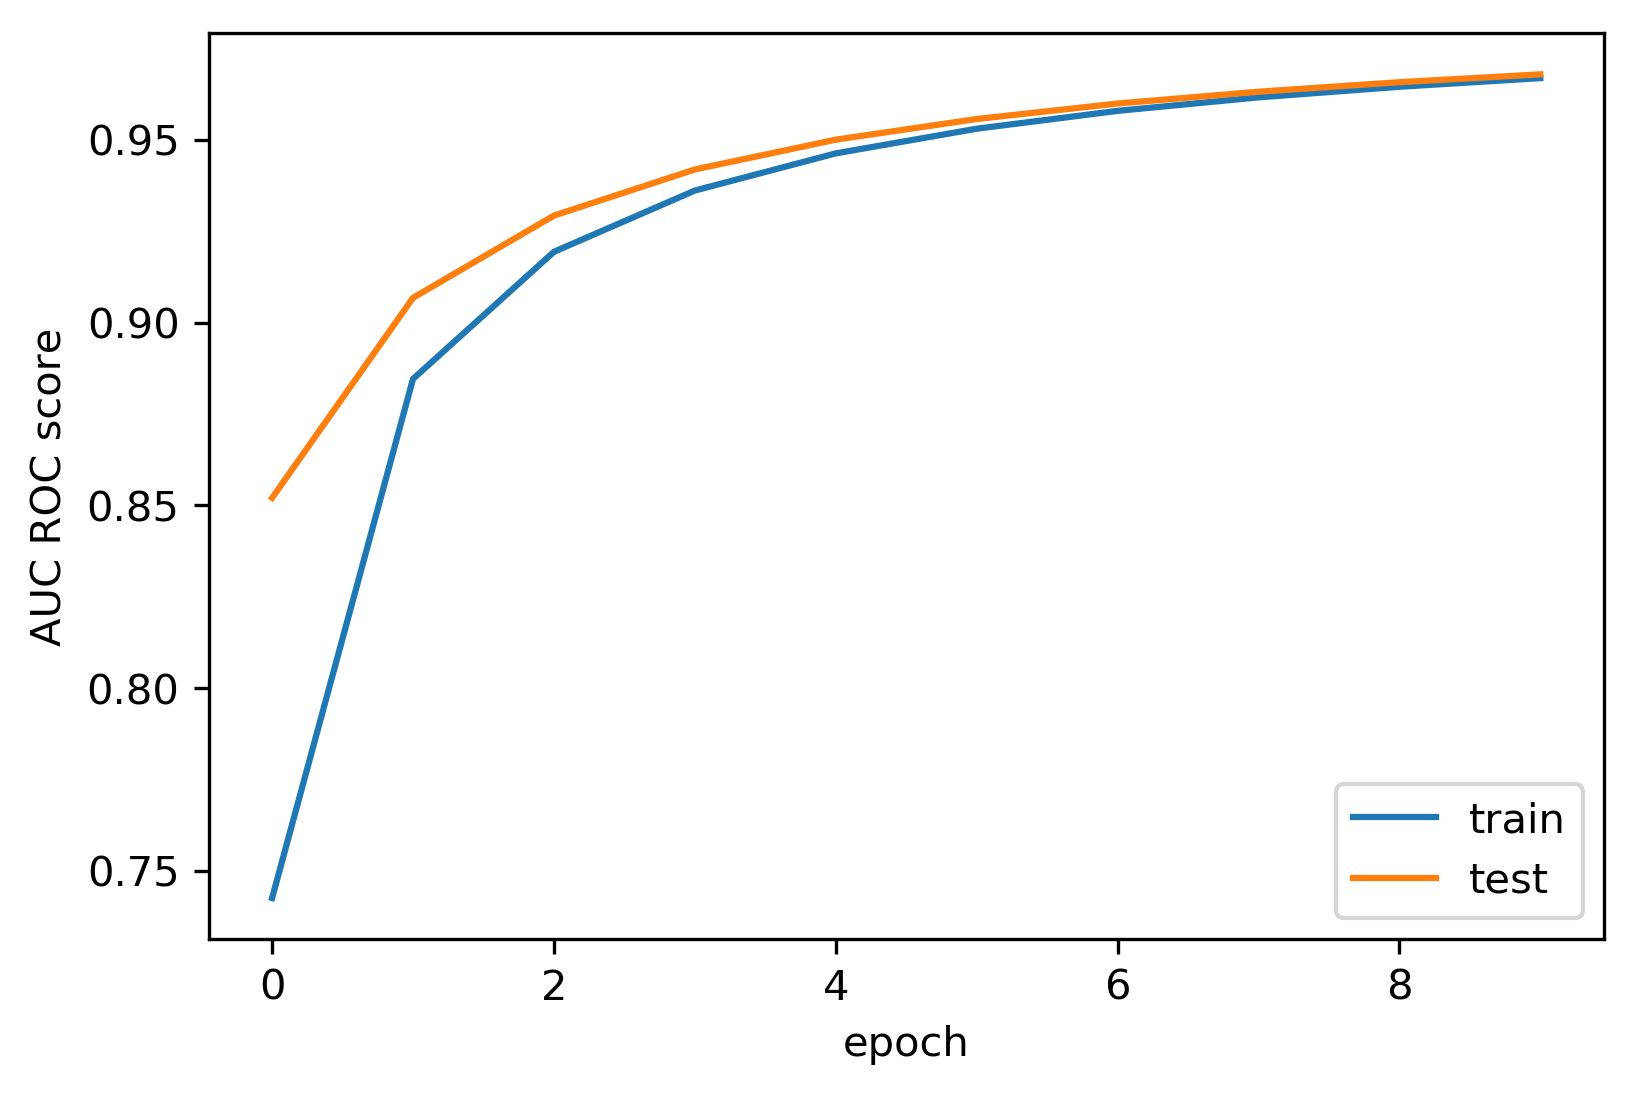

In [40]:
import matplotlib.pyplot as plt
plt.figure(dpi=300)
plt.plot(history.history['auc_roc'])
plt.plot(history.history['val_auc_roc'])
# plt.title('Link prediction performance')
plt.ylabel('AUC ROC score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Save Model

In [21]:
lstm_network.save("lstm_network_contrastive_eucl_256_linear_varlen_lncbase_filtered_conv2_random_e10.h5")

In [ ]:
siamese_net.summary()

In [ ]:
lstm_network.summary()

# Evaluate on test data

In [111]:
negative_sampling_ratio = 1.0
generator_Ed = DataGenerator(network=network_test, negative_sampling_ratio=negative_sampling_ratio,
                          maxlen=max_length, padding='post', truncating="pre",
                          batch_size=1, dim=input_shape, 
                          shuffle=True, seed=0)
generator_Ed.Eu_count = 0
generator_Ed.En_count = 0
generator_Ed.on_epoch_end()
# Ed_count: 72811 , Eu_count: 141062 , En_count: 130530, Ens_count: 145622
generator_Ed.Ed_count, generator_Ed.En_count, generator_Ed.Eu_count, generator_Ed.Ens_count

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: 2572
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 4858 , Eu_count: 3255 , En_count: 4570
Ens_count: 4858


(4858, 0, 0, 4858)

In [112]:
generator_Eu = DataGenerator(network=network_test, negative_sampling_ratio=negative_sampling_ratio,
                          maxlen=max_length, padding='post', truncating="post",
                          batch_size=1, dim=input_shape, 
                          shuffle=True, seed=0)
generator_Eu.Ed_count = 0
generator_Eu.Ens_count = 0
generator_Eu.on_epoch_end()
generator_Eu.Ed_count, generator_Eu.En_count, generator_Eu.Eu_count, generator_Eu.Ens_count

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: 2572
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 4858 , Eu_count: 3255 , En_count: 4570
Ens_count: 4858


(0, 4570, 3255, 0)

In [41]:
siamese_net.metrics_names

['loss', 'accuracy', 'precision', 'recall', 'auc_roc']

In [24]:
siamese_net.evaluate_generator(generator_Ed, use_multiprocessing=True, workers=8)

[0.06295261532068253,
 0.91796875,
 0.9035807847976685,
 0.8386380821466446,
 0.9678888320922852]

In [25]:
siamese_net.evaluate_generator(generator_Eu, use_multiprocessing=True, workers=8)

[0.016259223887962953,
 0.9898158482142857,
 0.9996481367519924,
 0.9760244573865619,
 0.9679112689835685]

# AUC Rate

In [42]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [ ]:
y = []
for i in generator_test.indexes:
    _, y_i = generator_test.__getitem__(i)
    y.append(y_i)

y_true = np.array(y)
y_true=y_true.reshape(y_true.shape[0], y_true.shape[-1])
y_true.shape

In [125]:
y_pred_keras = siamese_net.predict_generator(generator_test)
y_pred_keras.shape
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
# auc_keras = auc(fpr_keras, tpr_keras)

InternalError: CUB segmented reduce errorinvalid configuration argument
	 [[Node: replica_0/model_2/model_1/bidirectional_1/Sum = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](replica_0/model_2/model_1/bidirectional_1/zeros_like, replica_0/model_2/model_1/bidirectional_1/Sum/reduction_indices)]]
	 [[Node: replica_3/model_2/lambda_1/Sqrt/_2299 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:3", send_device_incarnation=1, tensor_name="edge_4300_replica_3/model_2/lambda_1/Sqrt", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
tf.nn.in_top_k(
    predictions=y_pred,
    targets=y_true,
    k=1000).eval()

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

# Inference

In [ ]:
np.set_printoptions(precision=2, suppress=True)

In [ ]:
i = 0
# i += 1
X, y = generator.__getitem__(i)
print("X:", [(k, v.shape) for k, v in X.items()], "\ny:", y.shape)
list(zip(siamese_net.predict_on_batch(X).flatten().tolist(), 
         y.flatten().tolist(), 
         X["is_directed"].tolist()))

In [ ]:
seqs = generator.get_sequence_data(range(len(generator.node_list)))

In [ ]:
embs = lstm_network.predict(seqs)

In [ ]:
embs.shape